# *Summary*
### In this notebook, the credit risk data was cleaned, explored for better understanding of the current credit risk situation, and modelled the data to accurately predict the probability of default of a loan. This can be used to automate approving and declining loan applcations more accurately.

### An 86% accuracy level was achieved in predicting the loan defaults on 32,576 loans and 12 benchmarks. With this model, the default rate would decrease by 8%, resulting in minimized risk for both the lender and applicant.
   


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import model_selection,linear_model, metrics

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv


In [2]:
cr_data = pd.read_csv("/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv")
shape = cr_data.shape
print("There are {} rows and {} features.".format(shape[0], shape[1]))
print(cr_data.dtypes)
cr_data

There are 32581 rows and 12 features.
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [3]:
# we will shorten the last 2 feature names and address the null values
cr_data = cr_data.rename(columns = {"cb_person_default_on_file":"default_hist", "cb_person_cred_hist_length": "cr_hist_len"})
cr_data.isnull().sum()

person_age                  0
person_income               0
person_home_ownership       0
person_emp_length         895
loan_intent                 0
loan_grade                  0
loan_amnt                   0
loan_int_rate            3116
loan_status                 0
loan_percent_income         0
default_hist                0
cr_hist_len                 0
dtype: int64

In [4]:
# percentage of null values from loan int rate col
cr_data.loan_int_rate.isnull().sum() / cr_data.shape[0]

0.0956385623522912

There are 2 features which has null values. Since the  relative to our sample size, we will investigate their distributions and decide how to fill the NaNs.

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


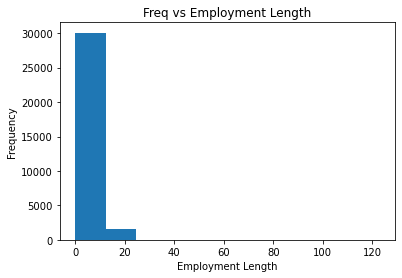

Text(0.5, 1.0, 'Freq vs Interest Rate')

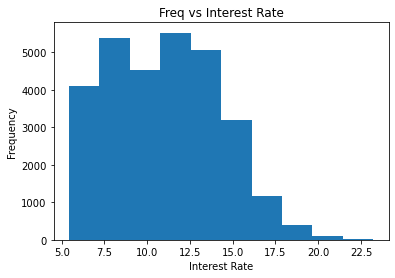

In [5]:
plt.hist(cr_data['person_emp_length'])
plt.xlabel("Employment Length")
plt.ylabel("Frequency")
plt.title("Freq vs Employment Length")
plt.show()

plt.hist(cr_data['loan_int_rate'])
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.title("Freq vs Interest Rate")

Both features are not normally distributed. Therefore we will fill the NaNs with the median values for both the loan interest rate and employment length features.

In [6]:
emp_len_null = cr_data[cr_data['person_emp_length'].isnull()].index
int_rate_null = cr_data[cr_data['loan_int_rate'].isnull()].index

cr_data['person_emp_length'].fillna((cr_data['person_emp_length'].median()), inplace=True)
cr_data['loan_int_rate'].fillna((cr_data['loan_int_rate'].median()), inplace = True)

Now let's consider if there are outliers.

Text(0.5, 1.0, 'Interest Rate vs Age')

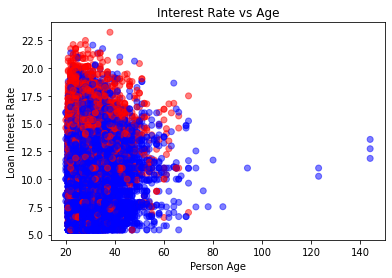

In [7]:
# check distribution of age and interest rate


colors = ["blue","red"]
plt.scatter(cr_data['person_age'], cr_data['loan_int_rate'],
            c = cr_data['loan_status'],
            cmap = mpl.colors.ListedColormap(colors), alpha=0.5)
plt.xlabel("Person Age")
plt.ylabel("Loan Interest Rate")
plt.title("Interest Rate vs Age")


There are individuals who are above 120 years of age with loans and are unlikely to apply for new loans in the future. Therefore we will remove individuals who exceed 100 years of age. 

There is no outlier for loan interest rates.

In [8]:
# Clean 1
cr_clean1 = cr_data[cr_data['person_age']<=100]

cr_data[cr_data['person_age']>100]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,default_hist,cr_hist_len
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0,0.02,N,3
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0,0.03,N,2
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0,0.25,N,3
747,123,78000,RENT,7.0,VENTURE,B,20000,10.99,0,0.26,N,4
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0,0.00,N,25


The entries shown above have been removed and created a cleaned dataset saved as `cr_clean1`.

In [9]:
pd.crosstab(cr_clean1['default_hist'], cr_clean1['loan_grade'])

loan_grade,A,B,C,D,E,F,G
default_hist,,,,,,,
N,10777,10448,3200,1750,499,129,28
Y,0,0,3256,1876,465,112,36


There is no surpise here as we see the lender focuses on issuing higher grade loans to clients with better credit history and less loans to those with worse credit history.

In [10]:
# note 0 is non default and 1 is default
default_hist_status_tab = pd.crosstab(cr_clean1['default_hist'], cr_clean1['loan_status'])
default_hist_status_tab

loan_status,0,1
default_hist,,
N,21895,4936
Y,3573,2172


In [11]:
total1 = default_hist_status_tab.iloc[0].sum()
defaulted1 = default_hist_status_tab.iloc[0,1]

total2 = default_hist_status_tab.iloc[1].sum()
defaulted2 = default_hist_status_tab.iloc[1,1]

first_default = round(defaulted1 / total1 * 100, 2)
second_default = round(defaulted2 / total2 * 100, 2)

print("Despite the measures taken, {}% of clients defaulted for the first time.".format(first_default))
print("And {}% of clients who had previously defaulted, defaulted again.".format(second_default))

Despite the measures taken, 18.4% of clients defaulted for the first time.
And 37.81% of clients who had previously defaulted, defaulted again.


In [12]:
pd.crosstab(cr_clean1['default_hist'], cr_clean1['loan_intent'], 
            values = cr_clean1['loan_int_rate'], aggfunc = 'median')

loan_intent,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE
default_hist,,,,,,
N,10.62,10.62,10.74,10.74,10.65,10.65
Y,14.09,13.85,14.09,14.11,14.10,13.99


Those who had not previously defaulted has a median loan interest rate 4% less than those who have defaulted. Issing a loan to client who may default has negative outcomes not only for the lender but also long term negative consequences for the client. We will use machine learning algorithms to improve credit risk modelling to reduce risk for both the lender and client.

In [13]:
cr_clean1

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,default_hist,cr_hist_len
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [14]:
# one hot encoding categorical variables
num_col = cr_clean1.select_dtypes(exclude = 'object')
char_col = cr_clean1.select_dtypes(include = 'object')

encoded_char_col = pd.get_dummies(char_col)

cr_clean2 = pd.concat([num_col, encoded_char_col], axis=1)
cr_clean2

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cr_hist_len,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,default_hist_N,default_hist_Y
0,22,59000,123.0,35000,16.02,1,0.59,3,0,0,...,0,0,0,0,1,0,0,0,0,1
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,30,1,0,...,0,0,0,1,0,0,0,0,1,0
32577,54,120000,4.0,17625,7.49,0,0.15,19,1,0,...,0,1,0,0,0,0,0,0,1,0
32578,65,76000,3.0,35000,10.99,1,0.46,28,0,0,...,0,0,1,0,0,0,0,0,1,0
32579,56,150000,5.0,15000,11.48,0,0.10,26,1,0,...,0,0,1,0,0,0,0,0,1,0


In [15]:
# Split Train and Test Sets
Y = cr_clean2['loan_status']
X = cr_clean2.drop('loan_status',axis=1)
 


x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, random_state=2020, test_size=.30)

#Start of Classification Logistics Regression

log_clf = linear_model.LogisticRegression()

log_clf.fit(x_train, np.ravel(y_train))

LogisticRegression()

In [16]:
col_effect = pd.DataFrame()
col_effect['col_names'] = X.columns
col_effect['col_coef'] = log_clf.coef_[0]
col_effect

,col_names,col_coef
0,person_age,-6.595057e-08
1,person_income,-4.041520e-05
2,person_emp_length,-2.328480e-08
3,loan_amnt,1.071947e-04
4,loan_int_rate,7.954648e-08
5,loan_percent_income,2.520093e-09
6,cr_hist_len,-1.243093e-08
7,person_home_ownership_MORTGAGE,-6.484666e-09
8,person_home_ownership_OTHER,2.063278e-11
9,person_home_ownership_OWN,-4.212456e-09


This tells  to deaultfor every one unit of increase in each column, the person is more likely when the coefficient is more positive and less likely when the coefficient is more negative.

In [17]:
int_val = float(log_clf.intercept_)
print('The overall probablity of non default is {:.3%}'.format(int_val))


The overall probablity of non default is -0.000%


We can use he previous the intercept and coefficient values of calculate the probability of default ( P = 1 ) and non default ( P = 0 ).

First we need the sum of the intercept and coefficients x column value. For example, int_coef_sum = intercept + [col_coef] X [col_values].

Then we can calculate the probabilities of default and non default witht eh logistic regression formula.

prob_default = 1/ (1 + np.exp(-int_coef_sum))

prob_nondefault = 1 - prob_default 

In [18]:
# first column is the logistic regression value
# second column is the predicted probability of default == 1
predict_log = pd.DataFrame(log_clf.predict_proba(x_test)[:,1], columns=['prob_default'])

pred_df = pd.concat([y_test.reset_index(drop=True), predict_log],axis=1)
pred_df

,loan_status,prob_default
0,0,0.292610
1,0,0.006268
2,0,0.370780
3,0,0.495510
4,0,0.216253
...,...,...
9768,0,0.407430
9769,0,0.330124
9770,1,0.471306
9771,0,0.231141


In [19]:
# check the accuracy
initial_accuracy = round(log_clf.score(x_test,  y_test),2)
print("The initial accuracy is {}".format(initial_accuracy))

The initial accuracy is 0.81


We want to whether there is a more suitable threshold to improve our accuracy.

In [20]:
thresh = np.linspace(0,1,21)
thresh

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [21]:
metrics.recall_score(pred_df.iloc[:,0],y_test, labels = [0,1])

1.0

In [22]:
def find_opt_thresh(predict,thr =thresh, y_true = y_test):
    data = predict
    
    def_recalls = []
    nondef_recalls = []
    accs =[]

    
    for threshold in thr:
        # predicted values for each threshold
        data['loan_status'] = data['prob_default'].apply(lambda x: 1 if x > threshold else 0 )
        
        accs.append(metrics.accuracy_score(y_true, data['loan_status']))
        
        stats = metrics.precision_recall_fscore_support(y_true, data['loan_status'])
        
        def_recalls.append(stats[1][1])
        nondef_recalls.append(stats[1][0])
        
        
    return accs, def_recalls, nondef_recalls

accs, def_recalls, nondef_recalls= find_opt_thresh(pred_df)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


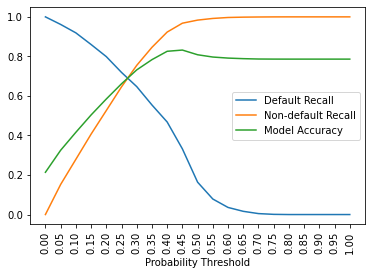

In [23]:
plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.xticks(thresh, rotation = 'vertical')
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
#plt.axvline(x=0.45, color='pink')
plt.show()


In [24]:
max_accuracy_index = accs.index(max(accs))

print('The maximum accuracy is {:.0%}.'.format(accs[max_accuracy_index]))
print('Therefore we should have a threshold of {:.0%}.'.format(thresh[max_accuracy_index]))

The maximum accuracy is 83%.
Therefore we should have a threshold of 45%.


# Further optimize the accuracy level with PCA

In [25]:
cr_clean2

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cr_hist_len,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,default_hist_N,default_hist_Y
0,22,59000,123.0,35000,16.02,1,0.59,3,0,0,...,0,0,0,0,1,0,0,0,0,1
1,21,9600,5.0,1000,11.14,0,0.10,2,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,1,0.57,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,1,0.53,2,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,1,0.55,4,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,30,1,0,...,0,0,0,1,0,0,0,0,1,0
32577,54,120000,4.0,17625,7.49,0,0.15,19,1,0,...,0,1,0,0,0,0,0,0,1,0
32578,65,76000,3.0,35000,10.99,1,0.46,28,0,0,...,0,0,1,0,0,0,0,0,1,0
32579,56,150000,5.0,15000,11.48,0,0.10,26,1,0,...,0,0,1,0,0,0,0,0,1,0


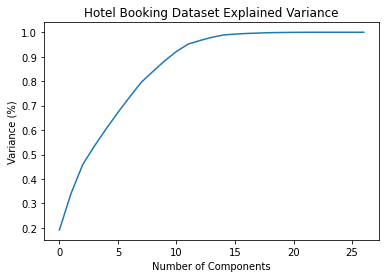

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=[0, 1])
data_rescaled = scaler.fit_transform(cr_clean2)

#Fitting the PCA algorithm with our Data
pca = PCA().fit(data_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Hotel Booking Dataset Explained Variance')
plt.show()

In the figure above, I have identified 14 components would be optiminal number to have the most simplied model with the most amount of information.

In [27]:
# normalize data
from sklearn import preprocessing
from sklearn.decomposition import PCA

pie = cr_clean2.drop('loan_status',axis=1)

data_scaled = pd.DataFrame(preprocessing.scale(pie),columns = pie.columns) 

# PCA
pca = PCA(n_components=14)
pca_val = pca.fit_transform(data_scaled)
pca_dataset = pd.DataFrame(pca_val)

In [28]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(pca_dataset, Y, random_state=2020, test_size=.32)

#Start of Classification Logistics Regression

log_clf = linear_model.LogisticRegression()

log_clf.fit(x_train, np.ravel(y_train))

# first column is the logistic regression value
# second column is the predicted probability of default == 1
pca_predict_log = pd.DataFrame(log_clf.predict_proba(x_test)[:,1], columns=['prob_default'])

pca_pred_df = pd.concat([y_test.reset_index(drop=True), predict_log],axis=1)
pca_pred_df

pca_accuracy = round(log_clf.score(x_test,  y_test),2)
pca_accuracy


0.86

We have improved the accuracy of our model from ****81% to 86%**** by leveraging ****Principle Component Analysis*** and ****hyperparameter tuning****.

The current process for credit assessment had a default rate of 22% as shown below. The new credit risk assessment algorithm which we had develop with principal component analysis and logistic regression had a reduced default rate from ****22% to 14%****  (1-0.86). 

The ****5% increase in accuracy resulted in the an 8% reduction of defaulted loans****, minimizing the lender's risk and improving their confidence to lend credit.

In [29]:
round(default_hist_status_tab.iloc[:,1].sum() / pca_dataset.shape[0],2)


0.22